In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: Moons Dataset

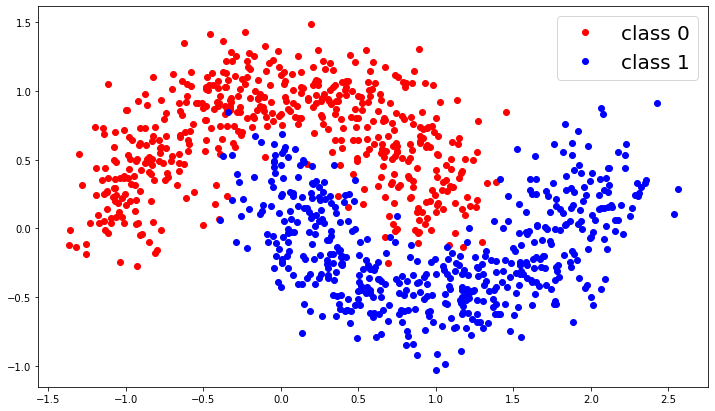

In [3]:
'generate two moon-shaped sets'
from sklearn.datasets import make_moons
X,labels = make_moons(n_samples=1000,noise=0.2)
plt.figure(figsize=(12,7))
colors = ['red','blue']
for i in range(2):
    plt.plot(X[labels==i,0],X[labels==i,1],'o',color=colors[i],label = 'class '+str(i))
plt.legend(fontsize=20)

1. Split the dataset into a training, a validation and a test sets

In [4]:
X_train,labels_train = X[:600],labels[:600]
X_val,labels_val = X[600:800],labels[600:800]
X_test,labels_test = X[800:],labels[800:]

2. Use the training set to train a Decision Tree. Use the validation set to find a good parameter (max_level) for the Decision Tree Classifier.

In [223]:
'Important functions'

'entropy function'
def entropy(p):
    if p!=0:
        return -p*np.log2(p)
    else:
        return 0
    
from collections import Counter
def proportions(labels):
    total = len(labels)
    return [count/total for count in Counter(labels).values()]

'entropy of a subset function'
def subset_entropy(proportions):
    return np.sum([entropy(p) for p in proportions])

'entropy of a partition function'
def entropy_partition(subsets):
    'returns the entropy from this partion of data into subsets'
    total_count = sum(len(subset) for subset in subsets)
    return sum(subset_entropy(subset)*len(subset)/total_count for subset in subsets)

'main function'
def decision_tree(X,labels,level=0,max_level=1):
    
    _,n_features = X.shape
    
    'let the algorithm choose the feature'
    p_list = np.zeros(n_features) 
    entropy_list = np.zeros(n_features)
    for feature in range(n_features):
    
        feature_grid = np.linspace(np.max(X[:,feature]),np.min(X[:,feature]),1000)
        entropy_grid = []
        for p in feature_grid:
            subset1 = labels[X[:,feature]>=p]
            subset2 = labels[X[:,feature]<p]
            subsets =[proportions(subset1), proportions(subset2)] #list of subset lists
            entropy_grid.append(entropy_partition(subsets))
        idx = np.argmin(entropy_grid) 
        p_list[feature] = feature_grid[idx]
        entropy_list[feature] = entropy_grid[idx]
    
    feature = np.argmin(entropy_list)
    optimal_p = p_list[feature]
    
    Tree = [optimal_p]    
    feature_Tree = [feature]
    
    #split subset X into two subsets
    X1,labels1 = X[X[:,feature]>=optimal_p], labels[X[:,feature]>=optimal_p]
    X2,labels2 = X[X[:,feature]<optimal_p], labels[X[:,feature]<optimal_p]
    
    label_Tree = []
    if len(labels1)>0: #if labels1 is not empty
        label_Tree.append(Counter(labels1).most_common()[0][0])
    else:
        label_Tree.append(9999)
    if len(labels2)>0:
        label_Tree.append(Counter(labels2).most_common()[0][0])
    else:
        label_Tree.append(9999)

    
    X_subsets = [X1,X2]
    labels_subsets = [labels1,labels2]
    
    if level<max_level:
        level = level+1
        
        Tree_next_level = []
        label_Tree_next_level = []
        feature_Tree_next_level = []
        for i in range(2):
            if len(labels_subsets[i])>0 and len(Counter(labels_subsets[i]))>1: #if nonempty and more than one class
                tree_list1,label_tree1,feature_list1 = decision_tree(X_subsets[i],labels_subsets[i],level=level,max_level=max_level)
                Tree_next_level.append(tree_list1)
                label_Tree_next_level.append(label_tree1)
                feature_Tree_next_level.append(feature_list1)
            else:
                Tree_next_level.append('stop')
                label_Tree_next_level.append('stop')
                feature_Tree_next_level.append('stop')
        
        Tree.append(Tree_next_level)
        label_Tree.append(label_Tree_next_level)
        feature_Tree.append(feature_Tree_next_level)
    return Tree,label_Tree,feature_Tree

def draw_partitions(Tree,feature_Tree,xlim,ylim,level=0,max_level=1):
    'only for bidimensional (two features) datasets'
    
    
    p = Tree[0]
    feature = feature_Tree[0]
    'draw the line'

    if feature==0: #vertical line
        plt.plot([p,p],ylim,'k')        
    else: #horizontal line
        plt.plot(xlim,[p,p],'k')
            

    'go one level deeper'        
    if level<max_level:
        if feature==0:
            level = level + 1
            Tree1 = Tree[1][0]
            Tree2 = Tree[1][1]
            xlim1 = [p,xlim[1]]
            xlim2 = [xlim[0],p]
            feature_Tree1 = feature_Tree[1][0]
            feature_Tree2 = feature_Tree[1][1]
            if Tree1!='stop':
                draw_partitions(Tree1,feature_Tree1,xlim1,ylim,level=level,max_level=max_level) 
            if Tree2!='stop':
                draw_partitions(Tree2,feature_Tree2,xlim2,ylim,level=level,max_level=max_level)
        else:
            level = level + 1
            Tree1 = Tree[1][0]
            Tree2 = Tree[1][1]
            ylim1 = [p,ylim[1]]
            ylim2 = [ylim[0],p]
            feature_Tree1 = feature_Tree[1][0]
            feature_Tree2 = feature_Tree[1][1]
            if Tree1 != 'stop':
                draw_partitions(Tree1,feature_Tree1,xlim,ylim1,level=level,max_level=max_level)
            if Tree2 != 'stop':
                draw_partitions(Tree2,feature_Tree2,xlim,ylim2,level=level,max_level=max_level)  
                
'classifier function'
def tree_classifier(tree,label_tree,feature_tree,new_point,max_level):
    next_level = True
    level = 0
    while level<max_level:
        feature = feature_tree[0]
        p = tree[0]
        if new_point[feature]>=p:
            new_label = label_tree[0]
            tree = tree[1][0]
            label_tree = label_tree[2][0]
            feature_tree = feature_tree[1][0]
            if label_tree == 'stop':
                return new_label
        else:
            new_label = label_tree[1]
            tree = tree[1][1]
            label_tree = label_tree[2][1]
            feature_tree = feature_tree[1][1]
            if label_tree == 'stop':
                return new_label
        level = level + 1
        
    'deepest level'
    p = tree[0]
    feature = feature_tree[0]
    if new_point[feature]>=p:
        new_label = label_tree[0]
    else:
        new_label = label_tree[1]
    return new_label

In [12]:
'Find the optimal max_level'
largest_max_level = 30

'train the model'
Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=largest_max_level)


p_incorrect = np.zeros(largest_max_level)
for max_level in range(largest_max_level):
    'Test the model on the validation set'
    labels_val_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_val[i],max_level=max_level)
                                  for i in range(len(labels_val))])
    'Percentage of incorrect classifications'
    p_incorrect[max_level] = 100*sum(labels_val_predicted!=labels_val)/len(labels_val)

Text(0.5, 1.0, 'percentage of incorrect classifications')

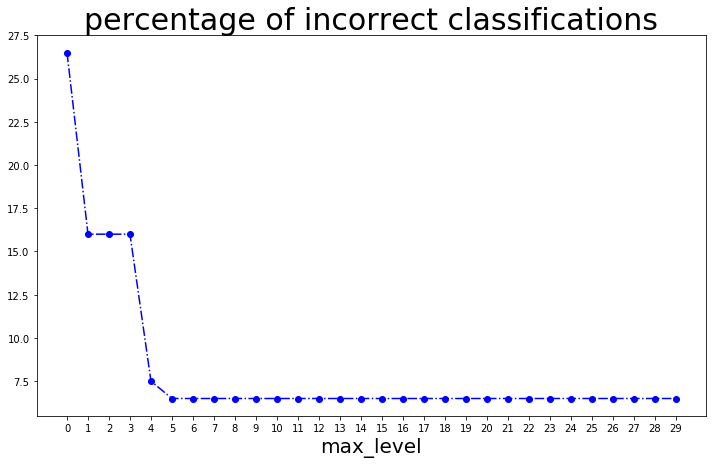

In [13]:
plt.figure(figsize=(12,7))
plt.plot(list(range(largest_max_level)),p_incorrect,'b-.o')
plt.xticks(list(range(largest_max_level)))
plt.xlabel('max_level',fontsize=20)
plt.title('percentage of incorrect classifications',fontsize=30)

In [16]:
max_level_optimal = 5 # from the above plot

(-1.0250809623394468, 1.4895220863236864)

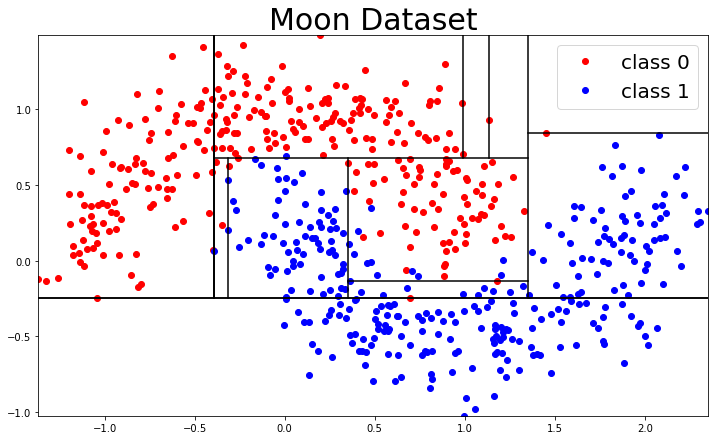

In [60]:
'let us have a look at the partitions'
plt.figure(figsize=(12,7))
for i in range(2):
    plt.plot(X_train[labels_train==i,0],X_train[labels_train==i,1],'o',color=colors[i],label = 'class '+str(i))
    plt.legend(fontsize=20)
plt.title('Moon Dataset',fontsize=30)


xlim = [np.min(X_train[:,0]),np.max(X_train[:,0])]
ylim = [np.min(X_train[:,1]),np.max(X_train[:,1])] 
draw_partitions(Tree,feature_Tree,xlim,ylim,max_level=max_level_optimal)
plt.xlim(xlim)
plt.ylim(ylim)

3. Measure your Decision Tree's performance on the test set. 

In [17]:
'Test the model on the test set'
labels_test_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_test[i],max_level=max_level_optimal)
                                  for i in range(len(labels_test))])

In [18]:
'Confusion matrix'
C = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        C[i,j] = sum(labels_test_predicted[labels_test==i]==j)
C

array([[97.,  1.],
       [ 6., 96.]])

In [19]:
'Percentage of correct classifications'
100*sum(labels_test_predicted==labels_test)/len(labels_test)

96.5

4. Grow a Random Forest by following these steps:    

(a) Generate 1000 subsets of the training set, each containing 100 instances selected randomly.

In [54]:
'Generate 1000 subsets each containing 100 data points selected randomly'
n_subsets = 1000
subset_size = 100

X_subsets = []
labels_subsets = []
for i in range(n_subsets):
    idx = np.random.permutation(len(labels_train)) #random permutation
    X_subsets.append(X_train[idx[:subset_size]])
    labels_subsets.append(labels_train[idx[:subset_size]])

(b) Train one Decision Tree on each subset, using the best max_level value found in Question 2.

In [55]:
Forest = [decision_tree(X_subsets[i],labels_subsets[i],max_level=max_level_optimal) for i in range(n_subsets)]

5. For each test set instance, generate the predictions of the 1000 Decision Trees, and keep only the most frequent    prediction.

In [56]:
def Forest_classifier(Forest,new_point,max_level):
    predictions = [tree_classifier(Tree[0],Tree[1],Tree[2],new_point,max_level) for Tree in Forest] 
    votes = Counter(predictions)
    return votes.most_common()[0][0] 

In [57]:
'Test the Forest on the test set'
labels_test_predicted = np.array([Forest_classifier(Forest,X_test[i],max_level=max_level_optimal)
                                  for i in range(len(labels_test))])

In [58]:
'Confusion matrix'
C = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        C[i,j] = sum(labels_test_predicted[labels_test==i]==j)
C

array([[81., 17.],
       [ 5., 97.]])

In [59]:
'Percentage of correct classifications'
100*sum(labels_test_predicted==labels_test)/len(labels_test)

89.0

# Part 2: the Zoo Dataset

The zoo dataset consists of 101 animals from a zoo.
There are 16 variables with various traits to describe the animals.
The 7 class types are: 

0 = Mammal

1 = Bird 

2 = Reptile 

3 = Fish

4 = Amphibian

5 = Bug

6 = Invertebrate

In [61]:
'load the data'
url = 'https://raw.githubusercontent.com/um-perez-alvaro/classification/master/zoo.csv'
zoo_data = pd.read_csv(url)
zoo_data.head(5)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


Train a Decision Tree (or a Random Forest) to predict the classification of the animals based upon the variables.

In [70]:
X = zoo_data.iloc[:,1:17].to_numpy()
labels = zoo_data.iloc[:,17].to_numpy()

In [72]:
len(labels)

101

In [241]:
X_train,labels_train = X[:70],labels[:70]
X_val,labels_val = X[70:85],labels[70:85]
X_test,labels_test = X[85:],labels[85:]
len(labels_train),len(labels_val),len(labels_test)

(70, 15, 16)

In [242]:
'train the Decision Tree'
largest_max_level = 20
Tree,label_Tree,feature_Tree = decision_tree(X_train,labels_train,max_level=largest_max_level)

p_incorrect = np.zeros(largest_max_level)
for max_level in range(largest_max_level):
    'Test the model on the validation set'
    labels_val_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_val[i],max_level=max_level)
                                  for i in range(len(labels_val))])
    'Percentage of incorrect classifications'
    p_incorrect[max_level] = 100*sum(labels_val_predicted!=labels_val)/len(labels_val)

Text(0.5, 1.0, 'percentage of incorrect classifications')

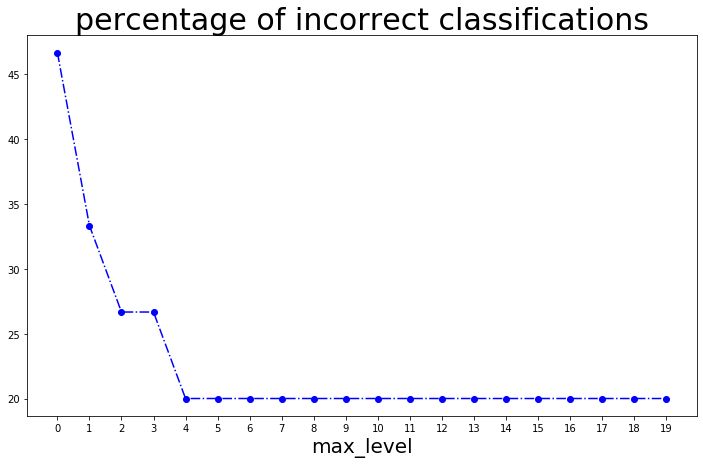

In [243]:
plt.figure(figsize=(12,7))
plt.plot(list(range(largest_max_level)),p_incorrect,'b-.o')
plt.xticks(list(range(largest_max_level)))
plt.xlabel('max_level',fontsize=20)
plt.title('percentage of incorrect classifications',fontsize=30)

In [244]:
Tree

[1.0,
 [[1.0,
   [[1.0,
     ['stop',
      [1.0,
       ['stop', [1.9979979979979978, [[1.0, ['stop', 'stop']], 'stop']]]]]],
    'stop']],
  [1.0, [[1.0, ['stop', 'stop']], [1.0, ['stop', 'stop']]]]]]

In [245]:
label_Tree

[1,
 2,
 [[1,
   4,
   [[1,
     1,
     ['stop', [1, 1, ['stop', [1, 3, [[1, 5, ['stop', 'stop']], 'stop']]]]]],
    'stop']],
  [2, 6, [[1, 2, ['stop', 'stop']], [6, 7, ['stop', 'stop']]]]]]

In [246]:
feature_Tree

[7,
 [[9,
   [[4, ['stop', [11, ['stop', [12, [[0, ['stop', 'stop']], 'stop']]]]]],
    'stop']],
  [8, [[0, ['stop', 'stop']], [9, ['stop', 'stop']]]]]]

In [253]:
'Test the Decision Tree'
labels_test_predicted = np.array([tree_classifier(Tree,label_Tree,feature_Tree,X_test[i],max_level=5)
                                  for i in range(len(labels_test))])

In [254]:
'Confusion matrix'
C = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        C[i,j] = sum(labels_test_predicted[labels_test==i+1]==j+1)
C

array([[4., 0., 0., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 1., 1.]])

In [255]:
'Percentage of correct classifications'
100*sum(labels_test_predicted==labels_test)/len(labels_test)

81.25

# Part 3: the King County Dataset 

The dataset kc_house_data contains house sale prices for King County, which includes Seattle.

In [3]:
'load the data'
url = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/kc_house_data.csv'
data = pd.read_csv(url)
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


There are 21 attributes

In [3]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

1. id: Unique ID for each home sold
2. data: Date of the home sale
3. price: Price of each home sold
4. bedrooms: Number of bedrooms
5. bathrooms: Number of bathrooms, where .5 accounts for a room with a toilet but no shower
6. sqft_living: Square footage of the apartments interior living space
7. sqft_lot: Square footage of the land space
8. floors: Number of floors
9. waterfront: A dummy variable for whether the apartment was overlooking the waterfront or not
10. view: An index from 0 to 4 of how good the view of the property was
11. condition: An index from 1 to 5 on the condition of the apartment
12. grade: An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
13. sqft_above: The square footage of the interior housing space hat is above ground level
14. sqft_basement: The square footage of the interior housing space that is below ground level
15. yr_built: The year the house was initially built
16. yr_renovated: The year of the house's last renovation
17. zipcode: What zipcode area the house is in
18. lat: Latitude
19. long: Longitude
20. sqft_living15: The square footage of interior housing living space for the nearest 15 neighbors
21. sqft_lot15: The square footage of the land lots of the nearest 15 neighbors.

The goal is to train a Decision Tree (or a Random Forest) to predict house prices.

In [2]:
'main function'
def decision_tree_regression(X,y,max_level,level=0):
    
    size = X.shape
    try:
        n_features = size[1]
    except IndexError:
        n_features = 1
        X = X[:,None] 
    'let the algorithm choose the feature'
    p_list = np.zeros(n_features) 
    MSE_list = np.zeros(n_features)
    for feature in range(n_features): #for each feature, find the best partition
        feature_grid = np.linspace(np.max(X[:,feature]),np.min(X[:,feature]),1000)
        MSE_grid = []
        for p in feature_grid: #for each partition, find the MSE
            'subset 1'
            X1 = X[X[:,feature]>=p]
            y1 = y[X[:,feature]>=p]
            if len(y1)>0:
                MSE1 = np.linalg.norm(y1-np.mean(y1))
            else:
                MSE1 = 0
            'subset 2'
            X2 = X[X[:,feature]<p]
            y2 = y[X[:,feature]<p]
            if len(y2)>0:
                MSE2 = np.linalg.norm(y2-np.mean(y2))
            else:
                MSE2 = 0
            'MSE of the partition'
            MSE_grid.append(MSE1+MSE2)
            
        idx = np.argmin(MSE_grid) 
        p_list[feature] = feature_grid[idx]
        MSE_list[feature] = MSE_grid[idx]
    

    feature = np.argmin(MSE_list)
    optimal_p = p_list[feature]
    
    Tree = [optimal_p]    
    feature_Tree = [feature]
    
    'two subsets'
    X1,y1 = X[X[:,feature]>=optimal_p], y[X[:,feature]>=optimal_p] # subset 1
    X2,y2 = X[X[:,feature]<optimal_p], y[X[:,feature]<optimal_p] # subset 2
    
    values_Tree = []
    if len(y1)>0: #if y1 is not empty
        values_Tree.append(np.mean(y1))
    else:
        values_Tree.append(0)
    if len(y2)>0:
        values_Tree.append(np.mean(y2))
    else:
        values_Tree.append(0)

    
    X_subsets = [X1,X2]
    y_subsets = [y1,y2]
    
    if level<max_level:
        level = level+1
        
        Tree_next_level = []
        values_Tree_next_level = []
        feature_Tree_next_level = []
        for i in range(2):
            if len(y_subsets[i])>0: #if the set is not empty
                new_tree_list,new_values_tree,new_feature_list = decision_tree_regression(X_subsets[i],
                                                                               y_subsets[i],
                                                                               max_level=max_level,
                                                                               level=level)
                Tree_next_level.append(new_tree_list)
                values_Tree_next_level.append(new_values_tree)
                feature_Tree_next_level.append(new_feature_list)
            else:
                Tree_next_level.append('stop')
                values_Tree_next_level.append('stop')
                feature_Tree_next_level.append('stop')
        
        Tree.append(Tree_next_level)
        values_Tree.append(values_Tree_next_level)
        feature_Tree.append(feature_Tree_next_level)
    return Tree,values_Tree,feature_Tree

'predictor function'
def tree_predictor(Tree,values_Tree,feature_Tree,new_point,max_level):
    next_level = True
    level = 0
    try: #check whether new_point is a scalar or a vector
        new_point[0]
    except IndexError: #new_point is a scalar
        new_point = new_point[None] #new_point is a 1-component vector
    while level<max_level:
        feature = feature_Tree[0]
        p = Tree[0]
        if new_point[feature]>=p:
            y_predicted = values_Tree[0]
            Tree = Tree[1][0]
            values_Tree = values_Tree[2][0]
            feature_Tree = feature_Tree[1][0]
            if values_Tree == 'stop':
                return y_predicted
        else:
            y_predicted = values_Tree[1]
            Tree = Tree[1][1]
            values_Tree = values_Tree[2][1]
            feature_Tree = feature_Tree[1][1]
            if values_Tree == 'stop':
                return y_predicted
        level = level + 1
        
    'deepest level'
    p = Tree[0]
    feature = feature_Tree[0]
    if new_point[feature]>=p:
        y_predicted = values_Tree[0]
    else:
        y_predicted = values_Tree[1]
    return y_predicted

Split the dataset into a training, a validation, and a test sets

In [5]:
'Add bathrooms per bedroom feature'
data_bedrooms = data.drop(data[data['bedrooms']==0].index) #remove houses with no bathrooms
data_bedrooms['bathrooms_per_bedroom'] = data_bedrooms['bathrooms']/data_bedrooms['bedrooms']

In [6]:
features = ['sqft_living','sqft_above','bathrooms_per_bedroom','lat'] 
X = data_bedrooms[features].to_numpy()
y = data_bedrooms['price'].to_numpy()
y_log = np.log(y)

In [7]:
'scale dataset'
X_scaled = (X-np.mean(X))/np.std(X)

In [8]:
X_train,y_train = X_scaled[:10000],y_log[:10000]
X_val,y_val = X_scaled[10000:15000],y_log[10000:15000]
X_test,y_test = X_scaled[15000:],y_log[15000:]

(a) Use the training set to train the model.
    
(b) Use the validation set to find the best parameters of the model.

In [9]:
'train the Decision Tree'
largest_max_level = 20
Tree,values_Tree,feature_Tree = decision_tree_regression(X_train,y_train,max_level=largest_max_level,level=0)

In [17]:
MSE = np.zeros(largest_max_level+1)
for max_level in range(largest_max_level+1):
    'Test the model on the validation set'
    y_val_predicted = np.array([tree_predictor(Tree,values_Tree,feature_Tree,X_val[i],max_level=max_level)
                                  for i in range(len(y_val))])
    'Mean squares error'
    MSE[max_level] = np.linalg.norm(y_val-y_val_predicted)/len(y_val)

Text(0.5, 1.0, 'Mean Squares Errors')

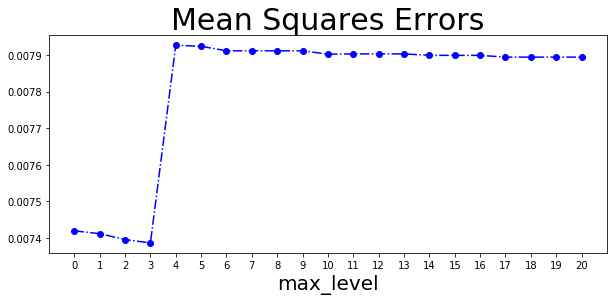

In [18]:
plt.figure(figsize=(10,4))
plt.plot(list(range(largest_max_level+1)),MSE,'b-.o')
plt.xticks(list(range(largest_max_level+1)))
plt.xlabel('max_level',fontsize=20)
plt.title('Mean Squares Errors',fontsize=30)

(c) Measure the performance of your model on the test set.  What MSE did you get?

In [19]:
max_level_optimal = 3

In [20]:
y_test_predicted = np.array([tree_predictor(Tree,values_Tree,feature_Tree,X_test[i],max_level=max_level_optimal)
                                  for i in range(len(y_test))])
'Mean squares error'
MSE = np.linalg.norm(np.exp(y_test)-np.exp(y_test_predicted))/len(y_test)
print(MSE)

4759.161582908065
